In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pickle

In [3]:
sales_train = pd.read_csv(r'sales_train_v2.csv')
items = pd.read_csv(r'items.csv')
item_categories = pd.read_csv(r'item_categories.csv')
shops = pd.read_csv(r'shops.csv')
sales_test = pd.read_csv(r'test.csv')

In [4]:
sales_test['ID'] = 34
sales_test.rename({'ID': 'date_block_num'}, axis = 1, inplace = True)
sales_test = sales_test.merge(items.loc[:,['item_category_id', 'item_id']], on = 'item_id', how = 'left')

In [5]:
sales_train = sales_train.merge(items.loc[:,['item_category_id', 'item_id']], on = 'item_id', how = 'left')

Create Sales column

In [6]:
sales_train['sales'] = sales_train['item_cnt_day']*sales_train['item_price']

Aggregating the data w.r.t shop id, item id and date_block_num

In [7]:
grouped_data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_shop_item', 'sales': 'sales_shop_item', 'item_price': 'price_shop_item'}, axis = 1).reset_index()

Aggregating the data wrt shop_id and date_block_num

In [8]:
aggdata = sales_train.groupby(['date_block_num', 'shop_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_shop', 'sales': 'sales_shop', 'item_price': 'price_shop'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'shop_id'])

Aggregating the data wrt item_id and date_block_num

In [9]:
aggdata = sales_train.groupby(['date_block_num', 'item_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_item', 'sales': 'sales_item', 'item_price': 'price_item'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'item_id'])

Aggregating the data wrt item_category_id and date_block_num

In [10]:
grouped_data = grouped_data.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')

In [11]:
aggdata = sales_train.groupby(['date_block_num', 'item_category_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_itcat', 'sales': 'sales_itcat', 'item_price': 'price_itcat'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'item_category_id'])

Appending the test data as well

In [12]:
grouped_data = grouped_data.append(sales_test, sort = False).fillna(0)

Splitting date to day, month and year

In [13]:
date_mat = sales_train.date.str.split('.', expand = True).astype('int32')
date_mat.columns = ['day', 'month', 'year']
date_df = pd.concat([sales_train['date_block_num'], date_mat[['month', 'year']]], axis = 1)
date_df.drop_duplicates(inplace = True)
date_df = date_df.append([{'date_block_num': 34, 'month': 11, 'year': 2015}])

In [14]:
grouped_data = grouped_data.merge(date_df, on = 'date_block_num', how = 'left')

In [15]:
grouped_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'cnt_shop_item',
       'sales_shop_item', 'price_shop_item', 'cnt_shop', 'sales_shop',
       'price_shop', 'cnt_item', 'sales_item', 'price_item',
       'item_category_id', 'cnt_itcat', 'sales_itcat', 'price_itcat', 'month',
       'year'],
      dtype='object')

Clipping the cnt_shop_item between 0 and 20 to remove outliers

In [16]:
grouped_data['cnt_shop_item'].clip(0,20, inplace = True)

In [17]:
del aggdata

Creating Expanding Mean Encodings

In [18]:
enc_feat = ['shop_id', 'item_id', 'item_category_id', 'month', 'year']
target_feat = ['cnt_shop_item', 'cnt_shop', 'cnt_item', 'cnt_itcat']

In [19]:
enc_df = grouped_data[['date_block_num', 'shop_id', 'item_id']].copy()
for i in enc_feat:
    for j in target_feat:
        cum_sum = grouped_data.groupby(i).cumsum()[j] - grouped_data[j]
        cum_count = grouped_data.groupby(i).cumcount()
        enc_df[i+'_enc_'+j] = cum_sum/(cum_count+1)   

In [20]:
enc_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'shop_id_enc_cnt_shop_item',
       'shop_id_enc_cnt_shop', 'shop_id_enc_cnt_item', 'shop_id_enc_cnt_itcat',
       'item_id_enc_cnt_shop_item', 'item_id_enc_cnt_shop',
       'item_id_enc_cnt_item', 'item_id_enc_cnt_itcat',
       'item_category_id_enc_cnt_shop_item', 'item_category_id_enc_cnt_shop',
       'item_category_id_enc_cnt_item', 'item_category_id_enc_cnt_itcat',
       'month_enc_cnt_shop_item', 'month_enc_cnt_shop', 'month_enc_cnt_item',
       'month_enc_cnt_itcat', 'year_enc_cnt_shop_item', 'year_enc_cnt_shop',
       'year_enc_cnt_item', 'year_enc_cnt_itcat'],
      dtype='object')

Creating Lagged Features

In [21]:
lag_feat = ['sales_shop_item', 'price_shop_item', 'sales_shop', 'price_shop',  
            'sales_item', 'price_item', 'sales_itcat', 'price_itcat']
lag_df = grouped_data[['date_block_num', 'shop_id', 'item_id']]
lag_int = [1,2]
for i in lag_int:
    key_df = grouped_data[['date_block_num', 'shop_id', 'item_id']+lag_feat].copy()
    key_df['date_block_num'] = key_df['date_block_num']+i
    lag_df = lag_df.merge(key_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left').fillna(0)
    lag_df.columns = [j + '_lag_'+ str(i) if j in lag_feat else j for j in lag_df.columns]

In [22]:
lag_feat = ['cnt_shop_item','cnt_shop', 'cnt_item', 'cnt_itcat']
lag_int = [1,2,3,4,5,6,12]
for i in lag_int:
    key_df = grouped_data[['date_block_num', 'shop_id', 'item_id'] + lag_feat].copy()
    key_df['date_block_num'] = key_df['date_block_num']+i
    lag_df = lag_df.merge(key_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left').fillna(0)
    lag_df.columns = [j + '_lag_'+ str(i) if j in lag_feat else j for j in lag_df.columns]
del key_df

In [23]:
lag_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'sales_shop_item_lag_1',
       'price_shop_item_lag_1', 'sales_shop_lag_1', 'price_shop_lag_1',
       'sales_item_lag_1', 'price_item_lag_1', 'sales_itcat_lag_1',
       'price_itcat_lag_1', 'sales_shop_item_lag_2', 'price_shop_item_lag_2',
       'sales_shop_lag_2', 'price_shop_lag_2', 'sales_item_lag_2',
       'price_item_lag_2', 'sales_itcat_lag_2', 'price_itcat_lag_2',
       'cnt_shop_item_lag_1', 'cnt_shop_lag_1', 'cnt_item_lag_1',
       'cnt_itcat_lag_1', 'cnt_shop_item_lag_2', 'cnt_shop_lag_2',
       'cnt_item_lag_2', 'cnt_itcat_lag_2', 'cnt_shop_item_lag_3',
       'cnt_shop_lag_3', 'cnt_item_lag_3', 'cnt_itcat_lag_3',
       'cnt_shop_item_lag_4', 'cnt_shop_lag_4', 'cnt_item_lag_4',
       'cnt_itcat_lag_4', 'cnt_shop_item_lag_5', 'cnt_shop_lag_5',
       'cnt_item_lag_5', 'cnt_itcat_lag_5', 'cnt_shop_item_lag_6',
       'cnt_shop_lag_6', 'cnt_item_lag_6', 'cnt_itcat_lag_6',
       'cnt_shop_item_lag_12', 'cnt_shop_lag_12', 

Exploiting text features in item category and item names

In [24]:
n_comp = 5

In [25]:
text_feat = ['item_id', 'item_category_id']
if 'item_id' in text_feat:
    text_df = items[['item_name', 'item_id']].copy()
    tv = TfidfVectorizer()
    tv_df = tv.fit_transform(text_df['item_name'])
    svd = TruncatedSVD(n_components=n_comp, random_state = 24)
    svd_df = svd.fit_transform(tv_df)
    svd_df = pd.DataFrame(data = svd_df, columns = ['item_name_' + str(i) for i in np.arange(1,n_comp+1)])
    item_name_df = pd.concat((text_df['item_id'], svd_df), axis = 1)
if 'item_category_id' in text_feat:
    text_df = item_categories.copy()
    tv = TfidfVectorizer()
    tv_df = tv.fit_transform(text_df['item_category_name'])
    svd = TruncatedSVD(n_components=n_comp, random_state = 24)
    svd_df = svd.fit_transform(tv_df)
    svd_df = pd.DataFrame(data = svd_df, columns = ['item_category_name_' + str(i) for i in np.arange(1,n_comp+1)])
    item_category_name_df = pd.concat((text_df['item_category_id'], svd_df), axis = 1)
del tv_df, svd_df, text_df, svd, tv

In [26]:
text_df = grouped_data[['date_block_num', 'shop_id', 'item_id', 'item_category_id']].copy()
text_df = text_df.merge(item_name_df, on = 'item_id', how = 'left')
text_df = text_df.merge(item_category_name_df, on = 'item_category_id', how = 'left')

In [27]:
text_df.drop('item_category_id', axis = 1, inplace = True)
text_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_name_1', 'item_name_2',
       'item_name_3', 'item_name_4', 'item_name_5', 'item_category_name_1',
       'item_category_name_2', 'item_category_name_3', 'item_category_name_4',
       'item_category_name_5'],
      dtype='object')

In [28]:
for df in [grouped_data, enc_df, lag_df, text_df]:
    print(df.shape)

(1823324, 18)
(1823324, 23)
(1823324, 47)
(1823324, 13)


Merging all the datasets to create the full set

In [29]:
full_data = grouped_data.copy()
key_feat = ['date_block_num', 'shop_id', 'item_id']
df = [enc_df, lag_df, text_df]
for i in df:
    full_data = full_data.merge(i, on = key_feat, how = 'left')

In [30]:
full_data.shape

(1823324, 92)

In [31]:
full_data.isnull().sum().sum()

0

In [32]:
del grouped_data, enc_df, lag_df, text_df

Dropping non required columns

In [33]:
to_drop = ['sales_shop_item', 'price_shop_item', 'cnt_shop', 'sales_shop', 'price_shop', 'cnt_item', 'sales_item', 'price_item',
           'cnt_itcat', 'sales_itcat', 'price_itcat']
full_data.drop(to_drop, axis=1, inplace = True)

In [34]:
full_data.shape

(1823324, 81)

In [35]:
def downcast_dtypes(data):
    float_cols = [c for c in data if data[c].dtype == "float64"]
    int_cols =   [c for c in data if data[c].dtype == "int64"]
    data[float_cols] = data[float_cols].astype(np.float32)
    data[int_cols]   = data[int_cols].astype(np.int32)
    return(data)

In [36]:
full_data = downcast_dtypes(full_data)

In [37]:
with open('full_data_2.pkl', 'wb') as handle:  
    pickle.dump(full_data,handle,protocol=-1)

Implementing a catboost model to find validation sets

In [36]:
def create_test(test):
    test = test.loc[(test['shop_id'].isin(sales_test['shop_id']))&(test['item_id'].isin(sales_test['item_id'])),:].copy()
    test_pred = test['cnt_shop_item'].copy()
    test.drop('cnt_shop_item', axis = 1, inplace = True)
    return(test, test_pred)

In [37]:
def error(pred, act):
    return(np.sqrt(np.sum(np.square(np.subtract(act,pred)))/sales_test.shape[0]))

In [38]:
def create_submission_file(pred, name):
    ID = np.arange(0, sales_test.shape[0]) 
    new_df = pd.DataFrame({'ID': ID, 'item_cnt_month': pred})
    new_df.to_csv('Submission Time Series/'+name+'.csv',index = False)

In [39]:
def create_cv_sets(months, data):
    train = []
    test = []
    train_pred = []
    test_pred = []
    for i in months:
        x = data.loc[full_data['date_block_num']<i,:].drop('cnt_shop_item', axis = 1)
        y_pred = data.loc[full_data['date_block_num']<i,'cnt_shop_item']
        x_test = data.loc[full_data['date_block_num']==i,:]
        x_test, y_test_pred = create_test(x_test)
        train.append(x)
        test.append(x_test)
        train_pred.append(y_pred)
        test_pred.append(y_test_pred)
    return(train,test,train_pred,test_pred) 

In [92]:
X_train, X_val, y_train, y_val = create_cv_sets([33], full_data)

In [100]:
alg = XGBRegressor(learning_rate = 0.2, n_estimators = 1000, max_depth = 5, min_child_weight = 5, gamma = 0, 
                   subsample = 0.9, colsample_bytree=0.6, eval_metric='rmse', seed = 42, n_jobs = 4)
xgtrain = xgb.DMatrix(X_train[0], y_train[0])
xgval = xgb.DMatrix(X_val[0], y_val[0])
xgb_params = alg.get_xgb_params()
watchlist = [(xgtrain, 'train'), (xgval, 'val')]
xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 1000, evals = watchlist,
                          early_stopping_rounds = 20, verbose_eval = 50)

[0]	train-rmse:2.65048	val-rmse:2.42855
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 20 rounds.
[50]	train-rmse:1.56967	val-rmse:1.52745
[100]	train-rmse:1.51913	val-rmse:1.51612
[150]	train-rmse:1.48193	val-rmse:1.49856
[200]	train-rmse:1.45735	val-rmse:1.48883
[250]	train-rmse:1.43821	val-rmse:1.48362
Stopping. Best iteration:
[240]	train-rmse:1.44155	val-rmse:1.48308



In [101]:
train, test, train_pred, _ = create_cv_sets([34], full_data)

In [112]:
alg = XGBRegressor(learning_rate = 0.2, n_estimators = 240, max_depth = 5, min_child_weight = 5, gamma = 0, 
                   subsample = 0.9, colsample_bytree=0.6, eval_metric='rmse', seed = 42, n_jobs = 4)
xgtrain = xgb.DMatrix(train[0], train_pred[0])
xgb_params = alg.get_xgb_params()
watchlist = [(xgtrain, 'train')]
xgbresults_test = xgb.train(xgb_params, xgtrain, num_boost_round=240, evals = watchlist, verbose_eval=50)

[0]	train-rmse:2.65703
[50]	train-rmse:1.57071
[100]	train-rmse:1.52025
[150]	train-rmse:1.48594
[200]	train-rmse:1.46315
[239]	train-rmse:1.44655


In [113]:
create_submission_file(xgbresults_test.predict(xgb.DMatrix(test[0])), 'xgb.csv')

In [41]:
train, test, train_pred, test_pred = create_cv_sets([31,32,33], full_data)

In [95]:
start = timer()
cat1 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 2, depth = 4, 
                        rsm = 1, learning_rate = 0.1, metric_period = 50)
cat1.fit(X_train[0].values, y_train[0].values, early_stopping_rounds=50, 
             eval_set=(X_val[0].values, y_val[0].values)) 
print('total time: %.5f' %(timer()-start))

0:	learn: 3.0820338	test: 2.8646589	best: 2.8646589 (0)	total: 517ms	remaining: 25m 51s
50:	learn: 1.7473039	test: 1.6580712	best: 1.6580712 (50)	total: 16.3s	remaining: 15m 44s
100:	learn: 1.6818579	test: 1.5991161	best: 1.5990582 (99)	total: 31.3s	remaining: 14m 59s
150:	learn: 1.6482527	test: 1.5783490	best: 1.5783490 (150)	total: 46.1s	remaining: 14m 29s
200:	learn: 1.6295163	test: 1.5694238	best: 1.5694238 (200)	total: 1m	remaining: 14m 1s
250:	learn: 1.6152085	test: 1.5592435	best: 1.5592435 (250)	total: 1m 14s	remaining: 13m 40s
300:	learn: 1.6032632	test: 1.5497676	best: 1.5497676 (300)	total: 1m 29s	remaining: 13m 19s
350:	learn: 1.5932351	test: 1.5438495	best: 1.5438495 (350)	total: 1m 43s	remaining: 13m 2s
400:	learn: 1.5835922	test: 1.5403534	best: 1.5402913 (399)	total: 1m 57s	remaining: 12m 44s
450:	learn: 1.5755781	test: 1.5363696	best: 1.5363696 (450)	total: 2m 12s	remaining: 12m 27s
500:	learn: 1.5679880	test: 1.5353920	best: 1.5351061 (495)	total: 2m 26s	remaining: 12

In [64]:
X_test,_ = create_test(full_data[full_data['date_block_num']==34])

In [65]:
create_submission_file(cat1.predict(X_test), 'cat1.csv')

Public Leader board score comes out to be 1.54

In [149]:
rc('figure', figsize=(15, 5))

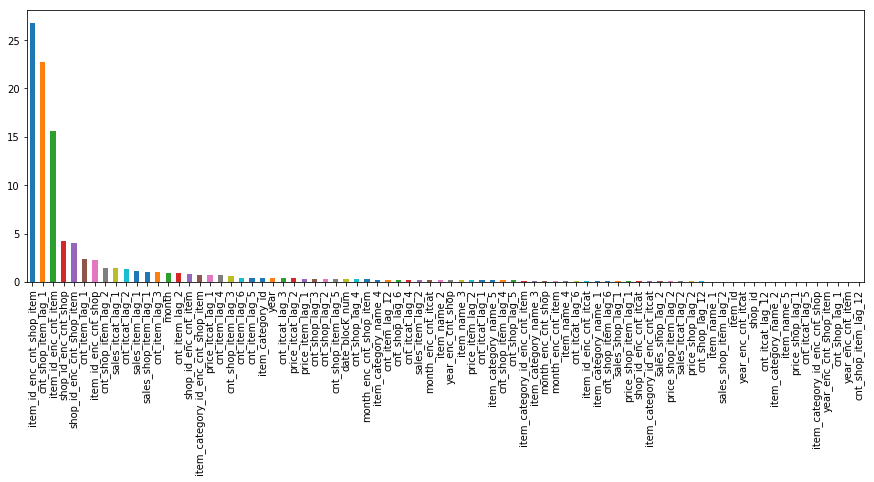

In [62]:
imp = cat1.get_feature_importance(prettified=True)
features = [int(i[0].decode("utf-8")) for i in imp]
features = X_train.columns[features]
pd.Series(data = [i[1] for i in imp], index=features).plot(kind= 'bar')

In [182]:
train, test, train_pred, test_pred = create_cv_sets([28,29,30,31,32,33], full_data)

In [183]:
cat2 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 2, depth = 4, 
                        rsm = 1, learning_rate = 0.2)
err2 = []
for X_train, X_val, y_train, y_val in zip(train, test, train_pred, test_pred):
    print('evaluating month %s ...'%(X_val.date_block_num.max()))
    cat2.fit(X_train.values, y_train.values, early_stopping_rounds=50, eval_set=(X_val.values, y_val.values), 
             logging_level = 'Silent')
    print('iterations: ', cat2.tree_count_)
    err2.append(cat2.score(X_val, y_val))
    print('error for month %s: %.5f' %((X_val.date_block_num.max()), cat2.score(X_val, y_val)))

evaluating month 28 ...
iterations:  482
error for month 28: 1.49117
evaluating month 29 ...
iterations:  772
error for month 29: 1.45207
evaluating month 30 ...
iterations:  373
error for month 30: 1.35050
evaluating month 31 ...
iterations:  324
error for month 31: 1.45541
evaluating month 32 ...
iterations:  342
error for month 32: 1.62588
evaluating month 33 ...
iterations:  598
error for month 33: 1.50708


In [184]:
np.mean(err2)

1.4803523775542526

In [186]:
2891/6

481.8333333333333

In [126]:
train, test, train_pred, _ = create_cv_sets([34], full_data)

In [127]:
cat2_test = CatBoostRegressor(iterations = 655, l2_leaf_reg = 2, depth = 4, 
                        rsm = 1, learning_rate = 0.2)
for X_train, y_train in zip(train, train_pred):
    cat2_test.fit(X_train.values, y_train.values, logging_level='Silent')

In [128]:
create_submission_file(cat2_test.predict(test[0]), 'cat2.csv')

Error on leaderboard - 1.56

In [187]:
train, test, train_pred, test_pred = create_cv_sets([28,29,30,31,32,33], full_data)

In [188]:
cat3 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 1, depth = 2, 
                        rsm = 1, learning_rate = 0.2)
err3 = []
for X_train, X_val, y_train, y_val in zip(train, test, train_pred, test_pred):
    print('evaluating month %s ...'%(X_val.date_block_num.max()))
    cat3.fit(X_train.values, y_train.values, early_stopping_rounds=50, eval_set=(X_val.values, y_val.values),
            logging_level='Silent')
    print('iterations: ', cat3.tree_count_)
    err3.append(cat3.score(X_val, y_val))
    print('error for month %s: %.5f' %((X_val.date_block_num.max()), cat3.score(X_val, y_val)))

evaluating month 28 ...
iterations:  623
error for month 28: 1.57198
evaluating month 29 ...
iterations:  1128
error for month 29: 1.50799
evaluating month 30 ...
iterations:  469
error for month 30: 1.41728
evaluating month 31 ...
iterations:  324
error for month 31: 1.52584
evaluating month 32 ...
iterations:  435
error for month 32: 1.71090
evaluating month 33 ...
iterations:  1326
error for month 33: 1.56175


In [189]:
np.mean(err3)

1.5492895744649624

In [179]:
train, test, train_pred, _ = create_cv_sets([34], full_data)

In [180]:
cat3_test = CatBoostRegressor(iterations = 1500, l2_leaf_reg = 1, depth = 2, 
                        rsm = 1, learning_rate = 0.2)
for X_train, y_train in zip(train, train_pred):
    cat3_test.fit(X_train.values, y_train.values, logging_level='Silent')

In [181]:
create_submission_file(cat3_test.predict(test[0]), 'cat3.csv')

Error on Leaderboard - 1.53

In [136]:
train, test, train_pred, test_pred = create_cv_sets([28, 29, 30, 31,32,33], full_data)

In [138]:
cat4 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 15, depth = 6, 
                        rsm = 1, learning_rate = 0.2)
err4 = []
for X_train, X_val, y_train, y_val in zip(train, test, train_pred, test_pred):
    print('evaluating month %s ...'%(X_val.date_block_num.max()))
    cat4.fit(X_train.values, y_train.values, early_stopping_rounds=50, eval_set=(X_val.values, y_val.values),
            logging_level='Silent')
    err4.append(cat4.score(X_val, y_val))
    print('error for month %s: %.5f' %((X_val.date_block_num.max()), cat4.score(X_val, y_val)))

evaluating month 28 ...
error for month 28: 1.48101
evaluating month 29 ...
error for month 29: 1.46002
evaluating month 30 ...
error for month 30: 1.36142
evaluating month 31 ...
error for month 31: 1.42904
evaluating month 32 ...
error for month 32: 1.58178
evaluating month 33 ...
error for month 33: 1.48302


In [141]:
np.mean(err4)

1.4660482932407417

In [142]:
cat4.tree_count_

488

In [135]:
np.mean(err3_p)

1.5162041383811458

In [143]:
train, test, train_pred, _ = create_cv_sets([34], full_data)

In [144]:
cat4_test = CatBoostRegressor(iterations = 489, l2_leaf_reg = 15, depth = 6, 
                        rsm = 1, learning_rate = 0.2)
for X_train, y_train in zip(train, train_pred):
    cat4_test.fit(X_train.values, y_train.values, logging_level='Silent')

In [145]:
create_submission_file(cat4_test.predict(test[0]), 'cat4_test.csv')

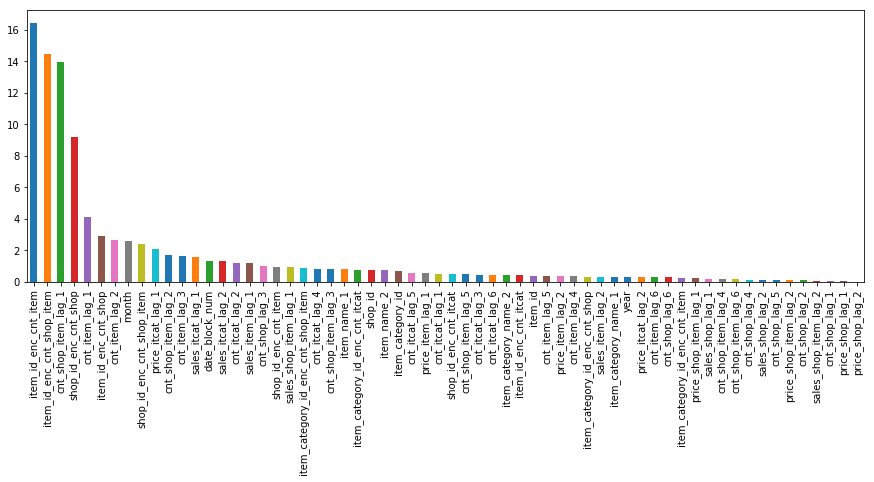

In [150]:
imp = cat4.get_feature_importance(prettified=True)
features = [int(i[0].decode("utf-8")) for i in imp]
features = X_train.columns[features]
pd.Series(data = [i[1] for i in imp], index=features).plot(kind= 'bar')

In [174]:
train, test, train_pred, test_pred = create_cv_sets([9,10,21,22], full_data)

In [175]:
cat5 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 15, depth = 6, 
                        rsm = 1, learning_rate = 0.2)
err5 = []
for X_train, X_val, y_train, y_val in zip(train, test, train_pred, test_pred):
    print('evaluating month %s ...'%(X_val.date_block_num.max()))
    cat5.fit(X_train.values, y_train.values, early_stopping_rounds=50, eval_set=(X_val.values, y_val.values),
            logging_level='Silent')
    err5.append(cat5.score(X_val, y_val))
    print('error for month %s: %.5f' %((X_val.date_block_num.max()), cat5.score(X_val, y_val)))

evaluating month 9 ...
error for month 9: 1.86461
evaluating month 10 ...
error for month 10: 1.87965
evaluating month 21 ...
error for month 21: 1.68715
evaluating month 22 ...
error for month 22: 1.68975


In [174]:
train, test, train_pred, test_pred = create_cv_sets([9,10,21,22], full_data)

In [178]:
cat6 = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 1, depth = 2, 
                        rsm = 1, learning_rate = 0.2)
err6 = []
for X_train, X_val, y_train, y_val in zip(train, test, train_pred, test_pred):
    print('evaluating month %s ...'%(X_val.date_block_num.max()))
    cat6.fit(X_train.values, y_train.values, early_stopping_rounds=50, eval_set=(X_val.values, y_val.values),
            logging_level='Silent')
    err6.append(cat6.score(X_val, y_val))
    print('error for month %s: %.5f' %((X_val.date_block_num.max()), cat6.score(X_val, y_val)))

evaluating month 9 ...
error for month 9: 2.08090
evaluating month 10 ...
error for month 10: 2.01758
evaluating month 21 ...
error for month 21: 1.83956
evaluating month 22 ...
error for month 22: 1.83282


Error on Leaderboard - 1.58

Last 2 months seem to be good validation sets

Trying another form of modeling where we use all the info but that month

In [61]:
def create_cv_sets2(months, data):
    X_train = data.loc[~data['date_block_num'].isin(months+[34]),:].drop('cnt_shop_item', axis=1)
    X_val = data.loc[data['date_block_num'].isin(months),:]
    X_val, y_val = create_test(X_val)
    X_test = data.loc[data['date_block_num'] == 34,:].drop('cnt_shop_item',axis=1)
    y_train = data.loc[~data['date_block_num'].isin(months+[34]),'cnt_shop_item']
    return(dict({'train': X_train, 'val': X_val, 'test': X_test, 'train_y': y_train, 'val_y': y_val}))

In [62]:
dict_cat = create_cv_sets2([9,21,33], full_data)

In [63]:
[i.shape for i in dict_cat.values()]

[(1483908, 62), (59742, 62), (214200, 62), (1483908,), (59742,)]

In [76]:
depth = [1,3,6,10]
err1 = []
n_tree = []
test_y = []
for d in depth:
    print('training for depth: {}...'.format(d))
    cat1 = CatBoostRegressor(iterations = 4000, l2_leaf_reg = 1, depth = d, 
                        rsm = 1, learning_rate = 0.2, metric_period = 200)
    cat1.fit(dict_cat['train'], dict_cat['train_y'], eval_set = (dict_cat['val'], dict_cat['val_y']), 
             early_stopping_rounds = 100)
    test_y.append(cat1.predict(dict_cat['test']))
    n_tree.append(cat1.tree_count_)
    print('n_trees: ', cat1.tree_count_)
    err1.append(cat1.score(dict_cat['val'], dict_cat['val_y']))
    print('error: ', cat1.score(dict_cat['val'], dict_cat['val_y']))

training for depth: 1...
0:	learn: 2.9457124	test: 3.2351800	best: 3.2351800 (0)	total: 192ms	remaining: 12m 47s
200:	learn: 1.8602080	test: 1.9782842	best: 1.9778840 (199)	total: 39.6s	remaining: 12m 28s
400:	learn: 1.8374875	test: 1.9513821	best: 1.9509247 (397)	total: 1m 19s	remaining: 11m 49s
600:	learn: 1.8274620	test: 1.9375525	best: 1.9375525 (600)	total: 1m 58s	remaining: 11m 11s
800:	learn: 1.8213901	test: 1.9302040	best: 1.9302040 (800)	total: 2m 38s	remaining: 10m 32s
1000:	learn: 1.8173435	test: 1.9269726	best: 1.9267369 (991)	total: 3m 17s	remaining: 9m 53s
1200:	learn: 1.8143419	test: 1.9233860	best: 1.9231803 (1178)	total: 3m 57s	remaining: 9m 13s
1400:	learn: 1.8119681	test: 1.9216809	best: 1.9214879 (1344)	total: 4m 37s	remaining: 8m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.921487888
bestIteration = 1344

Shrink model to first 1345 iterations.
n_trees:  1345
error:  1.9214878877390544
training for depth: 3...
0:	learn: 2.8887437	test: 3.

In [77]:
err1

[1.9214878877390544, 1.644208437439405, 1.6019516219577954, 1.5926690829678212]

In [78]:
n_tree

[1345, 1518, 492, 402]

In [79]:
test_y

[array([1.72668807, 0.83318219, 1.96814911, ..., 0.55921222, 0.40157118,
        1.41452957]),
 array([1.26791656, 1.27611849, 1.48385758, ..., 0.92259268, 1.01747371,
        1.23718158]),
 array([1.52081201, 1.31822184, 2.08162242, ..., 1.03253175, 1.07949464,
        1.16248167]),
 array([1.70202455, 1.42458317, 1.73219506, ..., 1.03040094, 0.89573067,
        1.20761434])]

In [80]:
test_ids = sales_test['item_id'].isin(sales_train['item_id']) & sales_test['shop_id'].isin(sales_train['shop_id'])

In [89]:
test_y_final = test_y.copy()

In [90]:
for i in range(len(test_y)):
    test_y_final[i] = [test_y[i][j] if test_ids[j] else 0 for j in range(len(test_ids))]

In [94]:
for i in range(len(test_y)):
    create_submission_file(test_y_final[i], 'catboost_'+str(i))

Optimizing the catboost parameters

In [47]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import seaborn as sns
from timeit import default_timer as timer
from numpy.random import RandomState
from hyperopt import STATUS_OK
import csv
import ast

In [98]:
dict_cat = create_cv_sets2([9,21,33], full_data)

In [116]:
def objective(params):
    global ITERATION
    ITERATION +=1
    print('ITERATION: %d' %(ITERATION))
    print('params: ', params)
    model = CatBoostRegressor(iterations = 5000, l2_leaf_reg=params['l2_leaf_reg'], learning_rate = 0.2,
                             rsm = params['rsm'], random_seed = 24, depth = params['depth'])
    start = timer()
    srtc = []
    model.fit(dict_cat['train'], dict_cat['train_y'], eval_set = (dict_cat['val'], dict_cat['val_y']), 
              early_stopping_rounds=100, logging_level='Silent')
    srtc.append(model.score(dict_cat['val'], dict_cat['val_y']))
    train_time = timer()-start
    loss = np.mean(srtc)
    print('loss: %.5f' %(loss))
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([ITERATION, loss, params, train_time])
    return {'iteration': ITERATION, 'loss': loss, 'params': params,   
            'train_time': train_time, 'n_trees': model.tree_count_, 'status': STATUS_OK}

In [117]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.quniform('l2_leaf_reg', 1, 100, 1),
    'rsm': 1 - hp.loguniform('rsm',np.log(0.65) , np.log(1)),
    'depth': hp.quniform('depth', 1, 15, 1)
}

In [118]:
sample(params_space)

{'depth': 5.0, 'l2_leaf_reg': 70.0, 'rsm': 0.5723828869886644}

In [119]:
out_file = 'cat_trials_pfs4.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['iteration', 'loss', 'params', 'train_time', 'n_trees'])
of_connection.close()

In [ ]:
trials = hyperopt.Trials()
global  ITERATION
ITERATION = 0
best = hyperopt.fmin(
    objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

ITERATION: 1
params:  {'depth': 4.0, 'l2_leaf_reg': 59.0, 'rsm': 0.5572495708621457}
loss: 1.61404
ITERATION: 2
params:  {'depth': 2.0, 'l2_leaf_reg': 37.0, 'rsm': 0.34512809960292457}
loss: 1.68277
ITERATION: 3
params:  {'depth': 13.0, 'l2_leaf_reg': 77.0, 'rsm': 0.022164425319898817}
loss: 1.64410
ITERATION: 4
params:  {'depth': 3.0, 'l2_leaf_reg': 70.0, 'rsm': 0.6240032305099308}
loss: 1.65573
ITERATION: 5
params:  {'depth': 7.0, 'l2_leaf_reg': 36.0, 'rsm': 0.7302578041491085}
loss: 1.58120
ITERATION: 6
params:  {'depth': 2.0, 'l2_leaf_reg': 46.0, 'rsm': 0.865277892292898}
loss: 1.68535
ITERATION: 7
params:  {'depth': 10.0, 'l2_leaf_reg': 59.0, 'rsm': 0.8280432743593791}
loss: 1.57424
ITERATION: 8
params:  {'depth': 14.0, 'l2_leaf_reg': 61.0, 'rsm': 0.5156078191294511}
